## Problem 1: It's not a bug, it's a feature! (20 points)

In this problem, we will ["open the black box"](https://news.yale.edu/2018/12/10/why-take-ydata-because-data-science-shouldnt-be-black-box) and inspect the filters and feature maps learned by a convolutional neural network trained to classify handwritten digits, using the MNIST database.

In [22]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [23]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train_binary = keras.utils.to_categorical(y_train, num_classes)
y_test_binary = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [24]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv1'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu", name='conv2'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 8, 8, 32)          25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0

In [25]:
batch_size = 128
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.1)

422/422 [==============================] - 49s 109ms/step - loss: 0.3953 - accuracy: 0.8767 - val_loss: 0.0829 - val_accuracy: 0.9807


In [26]:
score = model.evaluate(x_test, y_test_binary, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09216372668743134
Test accuracy: 0.9732000231742859


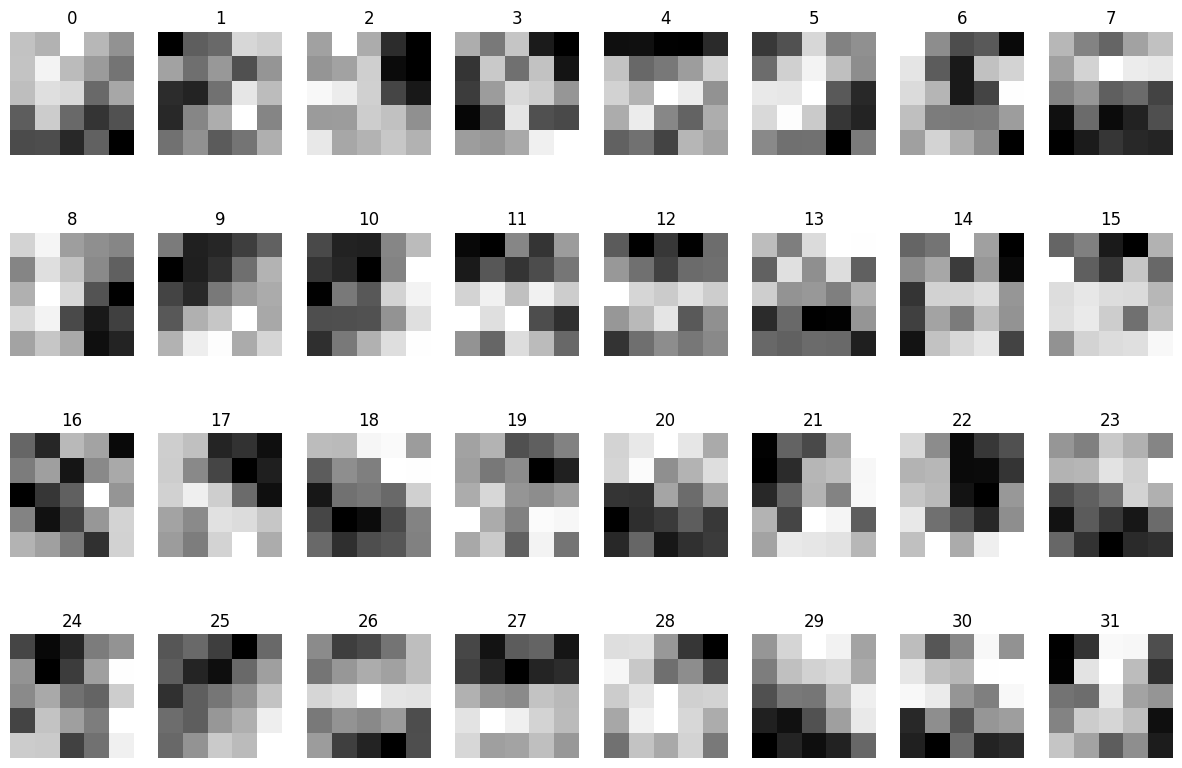

In [27]:
filters_conv1 = model.get_layer(name='conv1').get_weights()[0]

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(4):
    for j in range(8):
        f = filters_conv1[:, :, 0, 8*i+j]
        axs[i, j].imshow(f[:, :], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(8*i+j)

In [28]:
conv1_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv1').output)
feature_map_conv1 = conv1_layer_model(x_test)

In [29]:
sample_index = random.sample(range(1, len(x_test)), 16)

In [124]:
filter_n1 = 10
filter_n2 = 27

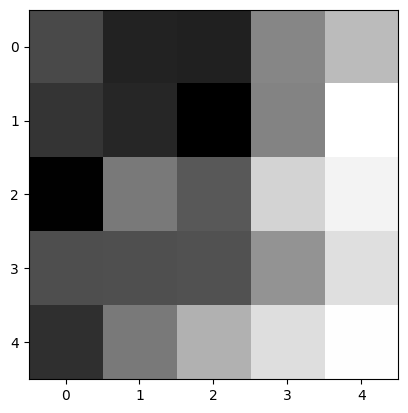

In [114]:
plt.imshow(filters_conv1[:, :, 0, filter_n1], cmap='gray')

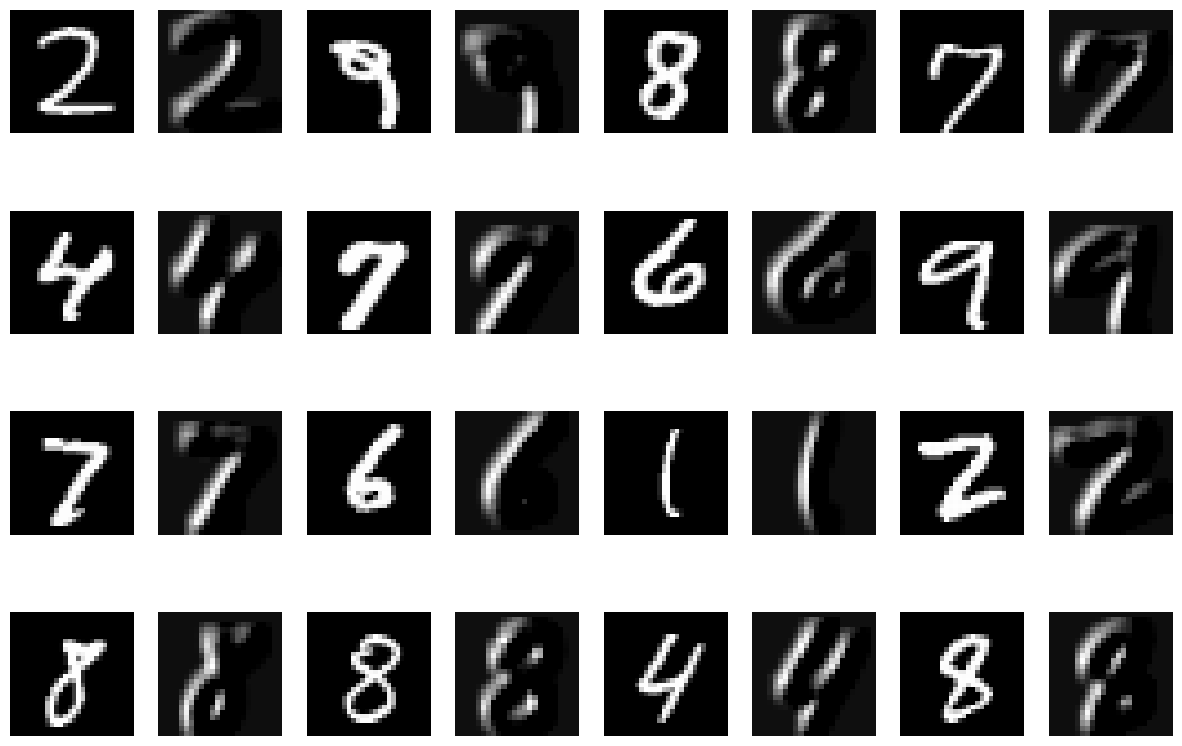

In [115]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n1], cmap='gray')
        axs[i, 2*j+1].axis('off')

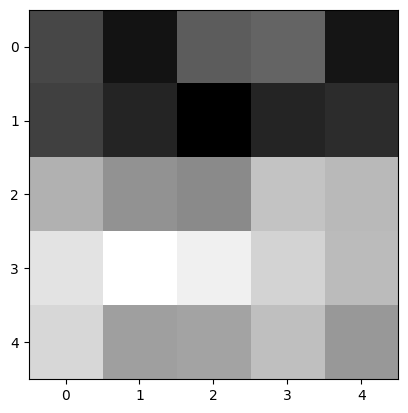

In [125]:
plt.imshow(filters_conv1[:, :, 0, filter_n2], cmap='gray')

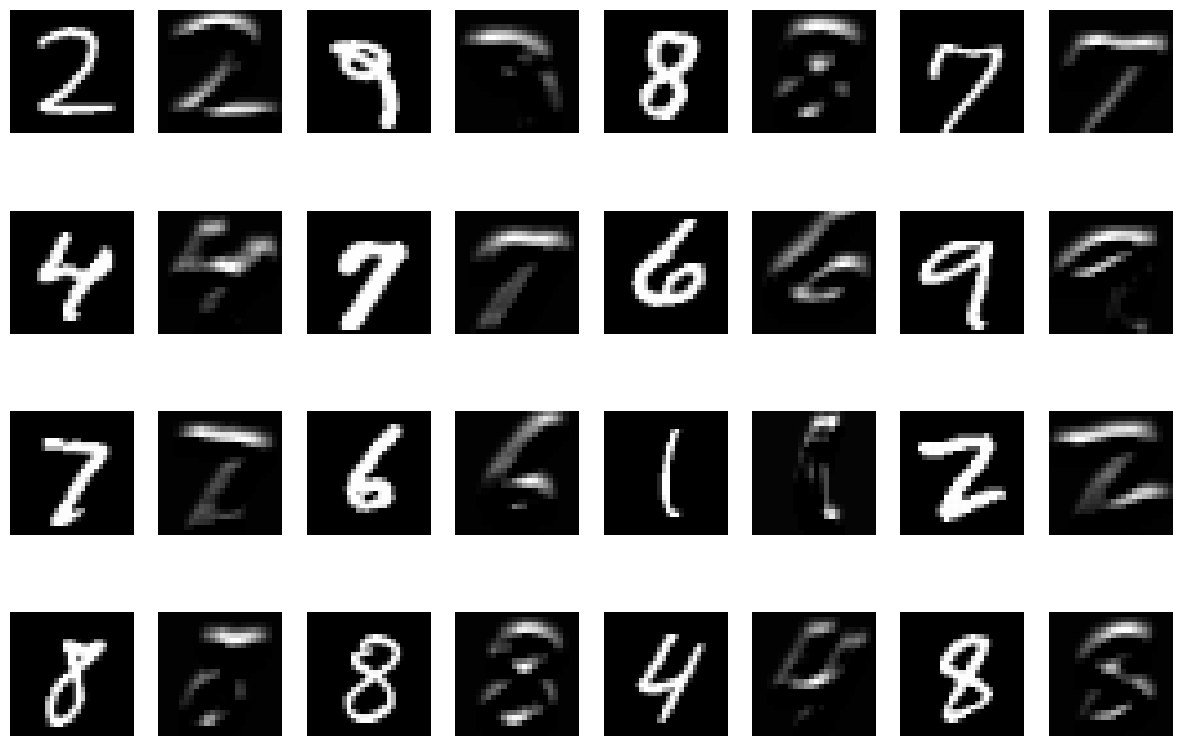

In [126]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv1[sample_index[4*i+j], :, :, filter_n2], cmap='gray')
        axs[i, 2*j+1].axis('off')

**Filter 10**

Feature map 10 seems to detect vertical edges on the right side of the original images. We see that straight lines and even slightly slanted to the right lines are picked up quite strongly by this filter due to weak weights given on a diagonal within the filter itself. We see things such as the slanted right leaning lines of the 7s detected in the feature maps by this filter for example. This would be helpful in abstracting numbers into where they commonly have vertical edges, which would be a very useful feature to have in a neural net.

**Filter 27**

Filter 27 seems to detect horizontal edges quite strongly. In the feature map, we see that the original images' horizontal edges are quite pronounced and highly activated whereas the more vertical lines are erased. This is due to how the filter has only high activation values in the lower 3 rows and little to no activation in the first two rows, creating a horizontal filter that only detects horizontal edges in the feature map. This is useful as it can detect commonly horizontal lines in particular numbers like the top of 7 and the absence of them in certain numbers like 1, which would be very good information for a neural net to have to predict numbers.

### 1.3 Fitting a logistic regression model on feature maps

The features of the images are further summarized after the second convolutional layer.

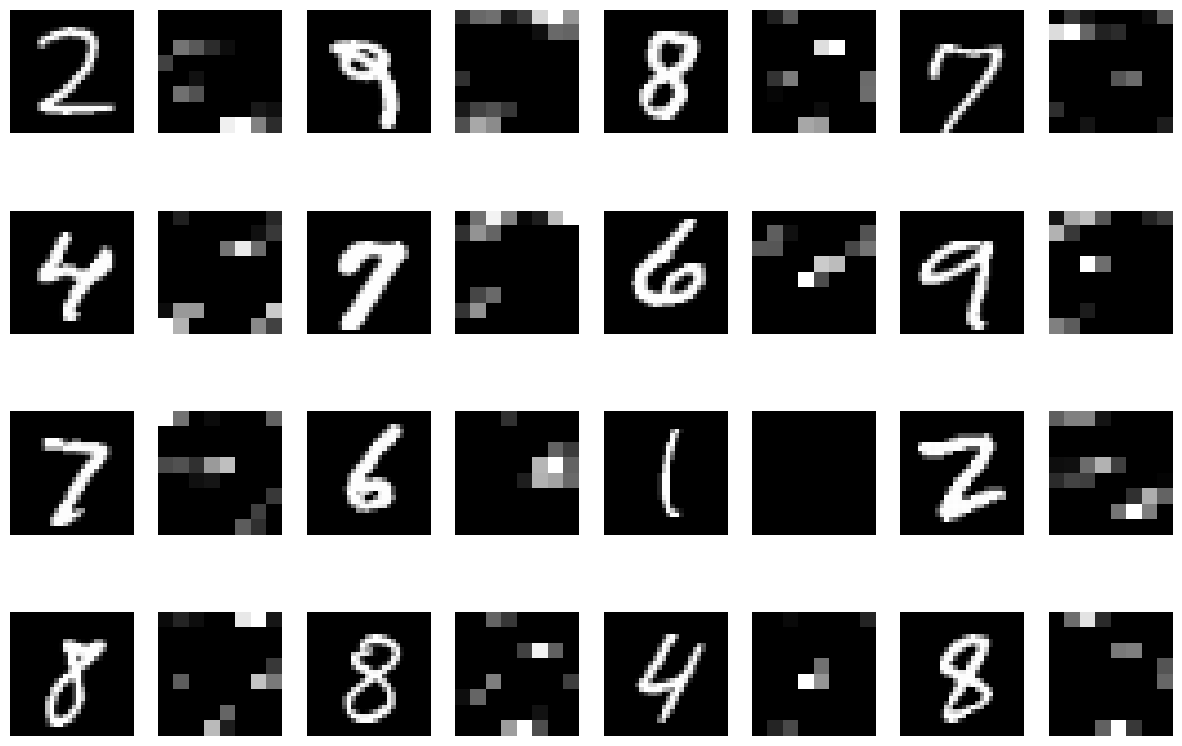

In [36]:
conv2_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('conv2').output)
feature_map_conv2 = conv2_layer_model(x_test)

fig, axs = plt.subplots(4, 8)
fig.set_figheight(10)
fig.set_figwidth(15)

ix=0
for i in range(4):
    for j in range(4):
        axs[i, 2*j].imshow(x_test[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j].axis('off')
        axs[i, 2*j+1].imshow(feature_map_conv2[sample_index[4*i+j], :, :, 0], cmap='gray')
        axs[i, 2*j+1].axis('off')

Build and test a logistic regression model to classify two digits of your choice (i.e. a binary classification) using the features maps at the second convolutional layer as the input. You may use logistic regression functions such as [LogisticRegression in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use 80% of the data for training and 20% for test.

* How many features are there in your input X? Show the derivation of this number based on the architecture of the convolutional neural network.

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

* What is the accuracy of your model? Is this expected, or surprising?

* Comment on any other aspects of your findings that are interesting to you.


In [78]:
X_lr = np.reshape(feature_map_conv2,(np.shape(feature_map_conv2)[0],-1))
y_lr = y_test

In [129]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Filter out samples for digits 3 and 8
mask = (y_test == 3) | (y_test == 8)
x_filtered = x_test[mask]
y_filtered = y_test[mask]

y_filtered = (y_filtered == 8).astype(int)

# Extract feature maps for these samples
feature_maps = conv2_layer_model.predict(x_filtered)

X = feature_maps.reshape(feature_maps.shape[0], -1)

X_train, X_test, y_train, y_testset = train_test_split(X, y_filtered, test_size=0.2)

# Initialize and train a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_testset, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


62/62 [==============================] - 1s 13ms/step
Accuracy: 99.75%


In [81]:
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of mask:", mask.shape)
print("Number of True values in mask:", mask.sum())
X_lr.shape


Shape of x_test: (10000, 28, 28, 1)
Shape of y_test: (10000,)
Shape of mask: (10000,)
Number of True values in mask: 1984


(10000, 2048)


* How many features are there in your input X? Show the derivation of this number based on the architecture of the convolutional neural network.

Due to the fact we only did the first 5x5 convolutional layer, a 2x2 pooling layer, and the second 5x5 convolutional layer but did not pool by the second 2x2 pooling layer, we ignore the last step of the CNN described in 1.1 and only calculate for the first 3 layers.

Beginning with 28x28x1, we run it through 32 5x5 filters, making it into 24x24x32 as there are now 32 features per original image and the 5x5 filter deletes 4 features in each dimension. then we pool by a 2x2 layer resulting in 12x12x32. Running this through another 5x5 convolutional layer, we get 12-4x12-4x32 = 8x8x32 features. 8x8x32 = 2048, which is the number of features we see in X

* How is your logistic regression model related to the fully connected layer and softmax layer in the convolutional neural network?

Feature Extraction: Both the logistic regression model and the CNN use feature maps from the convolutional layers for classification. In the CNN, the convolutional layers serve to extract spatial hierarchies of features from the input images. However, these feature maps are reshaped into a 2D array to be fed into the logistic regression model.

In a CNN: After feature extraction, the feature maps are usually passed through one or more fully connected (dense) layers. The purpose of these layers is to perform the actual classification based on the features extracted by the convolutional layers. The final dense layer has as many neurons as there are classes. The output of this layer is then passed through a softmax function, which will give a probability distribution over the classes.

In the logistic regression model: The logistic regression performs a similar role as the dense + softmax layers in the CNN. It takes the reshaped feature maps and learns to classify them into one of two classes (3 or 8). The logistic regression model will output a probability that the input belongs to class 1 (digit 8). This is analogous to the softmax layer giving a probability distribution over classes.

* What is the accuracy of your model? Is this expected, or surprising?

The accuracy seen is 99.75 percent, which is surprising but also speaks to the power of neural nets and a well tested dataset like MNIST and its learnability by CNNs.

## Problem 2: All that glitters (20 points)

In this problem you will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract
one event. You may write any GP code that you choose to, but please do not use any
package for Gaussian processes; your code should be "np-complete" (using only
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/sp22/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-fa22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact,
the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model.

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:

* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function
* `mean`: a mean function
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"

Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



In [52]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-sp22/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
print(events)

{'Javelin Throw Men', 'Discus Throw Women', '20Km Race Walk Men', '4X100M Relay Men', '3000M Steeplechase Women', '10000M Women', '4X400M Relay Men', 'Marathon Women', 'Decathlon Men', 'Long Jump Men', '20Km Race Walk Women', '800M Men', 'Triple Jump Men', 'Javelin Throw Women', '4X100M Relay Women', 'Pole Vault Women', '110M Hurdles Men', 'Hammer Throw Men', 'High Jump Men', '400M Women', '800M Women', '5000M Women', '5000M Men', '100M Hurdles Women', '400M Hurdles Women', 'High Jump Women', '4X400M Relay Women', '100M Women', 'Heptathlon Women', 'Long Jump Women', 'Discus Throw Men', '200M Men', '1500M Women', '100M Men', 'Marathon Men', '50Km Race Walk Men', '3000M Steeplechase Men', '400M Men', '10000M Men', '400M Hurdles Men', 'Shot Put Men', '200M Women', '1500M Men', 'Triple Jump Women', 'Pole Vault Men', 'Hammer Throw Women', 'Shot Put Women'}


We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

Enter your code and markdown following this cell.

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
from scipy.spatial.distance import cdist
from IPython.display import clear_output
from time import sleep

#Kernel function
def K_fun(X1, X2, h=12):
    K = np.zeros((len(X1), len(X2)))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            K[i, j] = np.exp(-0.5 * (x1 - x2)**2 / h**2)
    return K

# Mean function
def mu_fun(x, b=0):
    return b * np.ones(len(x))

# Function to sample from Gaussian
def gaussian_sample(mu, cov):
    A = cholesky(cov)
    Z = np.random.normal(loc=0, scale=1, size=len(mu))
    return mu + A @ Z

# Main function to perform GP and plot
def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    # Training data
    Xtrain = year
    ftrain = result

    # Compute the kernel
    K = kernel(Xtrain, Xtrain)
    xs = np.linspace(min(year) - 1, max(year) + 10, 500)
    Ks = kernel(Xtrain, xs)
    sigma2 = noise
    Kss = kernel(xs, xs) + sigma2 * np.eye(len(xs))
    Ki = np.linalg.inv(K + sigma2 * np.eye(len(Xtrain)))

    # Compute the posterior mean and covariance
    postMu = mu_fun(xs, mean) + Ks.T @ Ki @ (ftrain - mu_fun(Xtrain, mean))
    postCov = Kss - Ks.T @ Ki @ Ks

    # Sample from posterior
    fs = gaussian_sample(postMu, postCov)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    S2 = np.diag(postCov)
    ax.fill_between(xs, postMu - 2 * np.sqrt(S2), postMu + 2 * np.sqrt(S2),
                    alpha=0.2, label='Posterior 95% confidence')
    ax.plot(xs, postMu, c='blue', label='Posterior Mean')
    ax.plot(xs, fs, c='red', linestyle='-', linewidth=0.2, label='Sample from Posterior')
    ax.scatter(Xtrain, ftrain, color='black', marker='o', linewidth=.4)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(event_name, fontsize=14)
    ax.legend()
    plt.show()

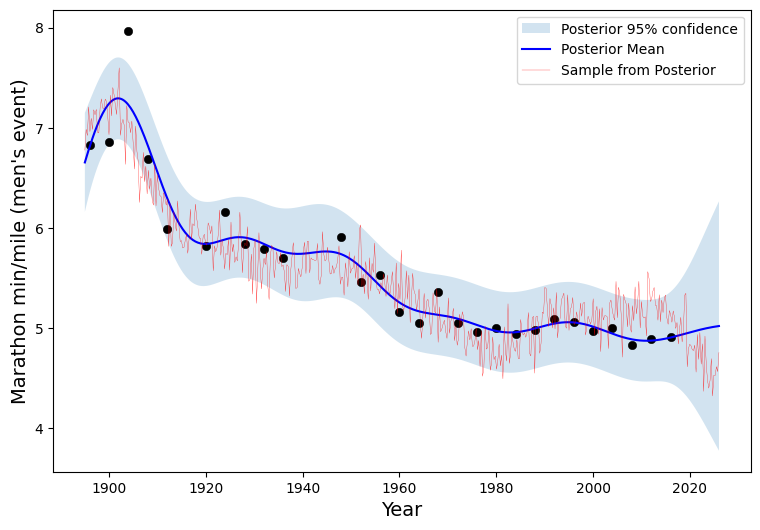

In [198]:
# Marathon Men
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
marathonyear = np.array(marathon['Year'])
marathonresult = np.array(marathon['Minutes per Mile'])

mean = 5
gp_olympic_event(marathonyear, marathonresult, K_fun, mean, 0.03, "Marathon min/mile (men's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

* Why the plot does or doesn't look satisfactory to you

This plot looks satisfactor as for the large majority of the years, the posterior mean seems to fit the data quite well and has a tight 95% confidence interval.

* If there are any events such as the 1904 marathon that are notable.

This is the marathon dataset that includes the infamous 1904 marathon.

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean trends toward the overall mean of the data points.

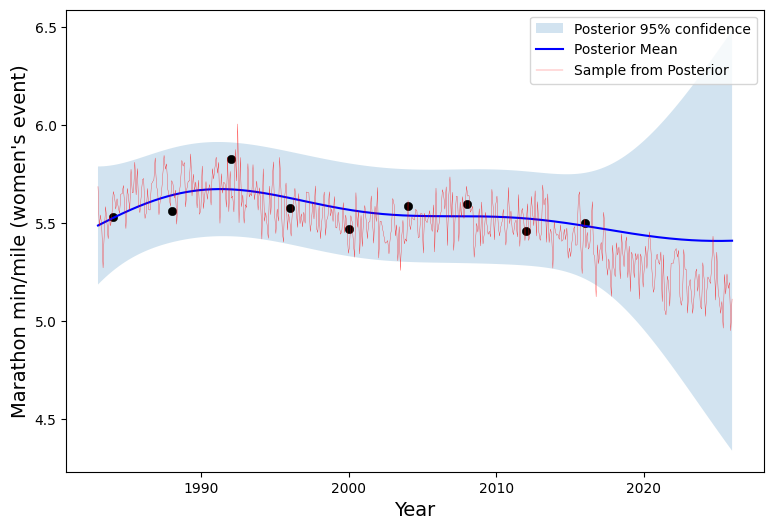

In [199]:
# Marathon Women
marathonwomen = dat[dat['Event'] == 'Marathon Women']
marathonwomen = marathonwomen[marathonwomen['Medal']=='G']
marathonwomen = marathonwomen.sort_values('Year')
time = np.array(marathonwomen['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathonwomen['Minutes per Mile'] = np.round(mpm,2)
marathonwomen = marathonwomen.drop(columns=['Gender', 'Event'], axis=1)
marathonwomen.reset_index(drop=True, inplace=True)
womenmarathonyear = np.array(marathonwomen['Year'])
womenmarathonresult = np.array(marathonwomen['Minutes per Mile'])

mean = sum(mpm)/len(mpm)
gp_olympic_event(womenmarathonyear, womenmarathonresult, K_fun, mean, 0.01, "Marathon min/mile (women's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

* Why the plot does or doesn't look satisfactory to you

This plot looks only somewhat satisfactory as for the large majority of the years, the posterior mean seems to fit the data quite well and has a somewhat tight 95% confidence interval but the lack of data points in recent years causes a rapid expansion of the CI. However due to the little amount of data even overall, this is expected.

* If there are any events such as the 1904 marathon that are notable.

This marathon dataset also includes a min/mile time that seems relatively very high that occured in the early 90s.

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean trends toward the overall mean of the data points.

* Something interesting

It's interesting how the women's times haven't decreased too much but it might also be because of the short time interval.

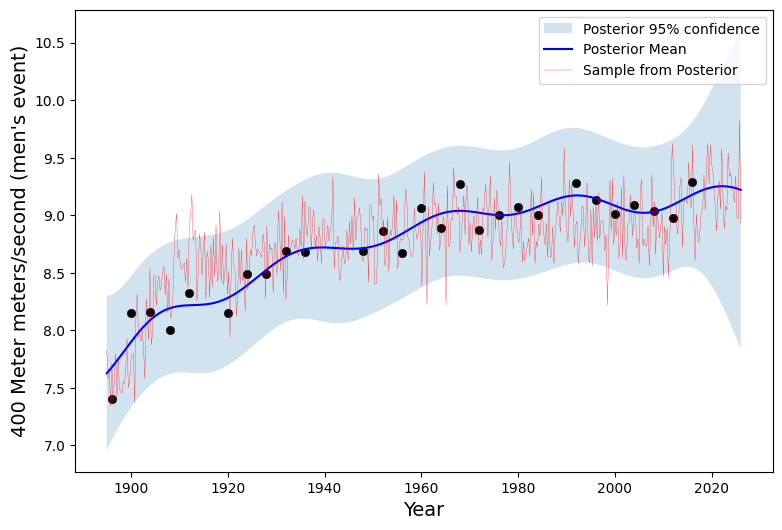

In [241]:
# 400 Meter Men
event_name = '400M Men'
event_info = dat[dat['Event'] == event_name]
event_info = event_info[event_info['Medal']=='G']
event_info = event_info.sort_values('Year')
year = np.array(event_info['Year'])
time = np.array(event_info['Result'])
mps = []
for tm in time:
  if (tm[1] == ':'):
    tm = tm[2:]
  t = np.array(tm.split('.'), dtype=float)
  meters_per_second = (400/(t[0] + t[1]/60))
  mps.append(meters_per_second)
result = np.array(mps)
mean = sum(mps)/len(mps)
noise = 0.06
gp_olympic_event(year, result, K_fun, mean, noise, "400 Meter meters/second (men's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

In this particular case, I balanced having a tighter CI with also adjusting for the apparent noise in the data and thus slightly increased the noise parameter compared to before

* Why the plot does or doesn't look satisfactory to you

This plot looks only satisfactory as for the large majority of the years, the posterior mean seems to fit the data quite well and has a somewhat tight 95% confidence interval. I would have liked a smoother and less volatile posterior mean but it was hard to smoothen it due to the CI growing too wide when adjusting noise. Maybe a higher h would have been better for this case but i wanted to keep h consistent for the sake of comparisons

* If there are any events such as the 1904 marathon that are notable.

We again see a gap during the years of WWII.

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean trends toward the overall mean of the data points.

* Something interesting

We see a consistent increase in speeds between the 20s and 60s but it seems to be levelling out now

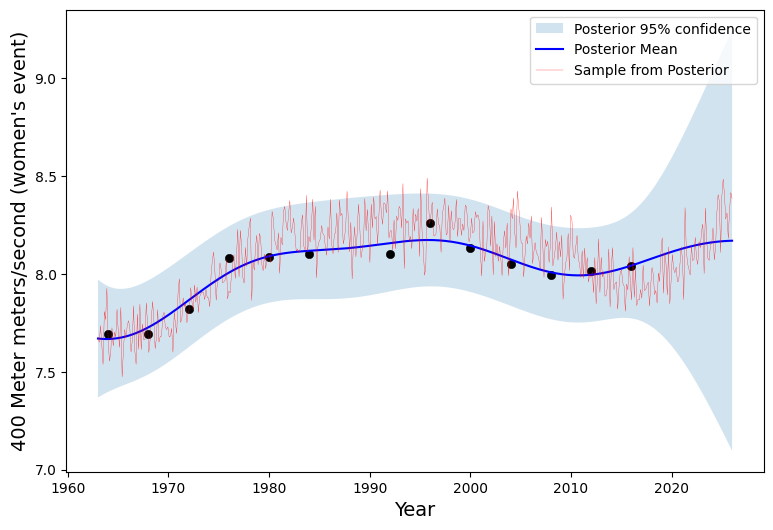

In [243]:
# 400 Meter Women
event_name = '400M Women'
event_info = dat[dat['Event'] == event_name]
event_info = event_info[event_info['Medal']=='G']
event_info = event_info.sort_values('Year')
year = np.array(event_info['Year'])
time = np.array(event_info['Result'])
mps = []
for tm in time:
  t = np.array(tm.split('.'), dtype=float)
  meters_per_second = (400/(t[0] + t[1]/60))
  mps.append(meters_per_second)
result = np.array(mps)
mean = sum(mps)/len(mps)
noise = 0.01
gp_olympic_event(year, result, K_fun, mean, noise, "400 Meter meters/second (women's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

In this particular case, I saw that the data didn't appear too noisy and thus explored a few low noises until the plot looked satisfactory.

* Why the plot does or doesn't look satisfactory to you

This plot looks  satisfactory as for the large majority of the years, the posterior mean seems to fit the data quite well and has a somewhat tight 95% confidence interval. The function looks quite smooth but once again like the previous womens' event, the lack of data causes a huge widening of the CI.

* If there are any events such as the 1904 marathon that are notable.

Not particularly

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean follows where it was going but slowly trends toward the overall mean of the data points.

* Something interesting

The increase in speeds from 1970 to 1990 and then subsequent drop as we entered the 2000s was odd and interesting.

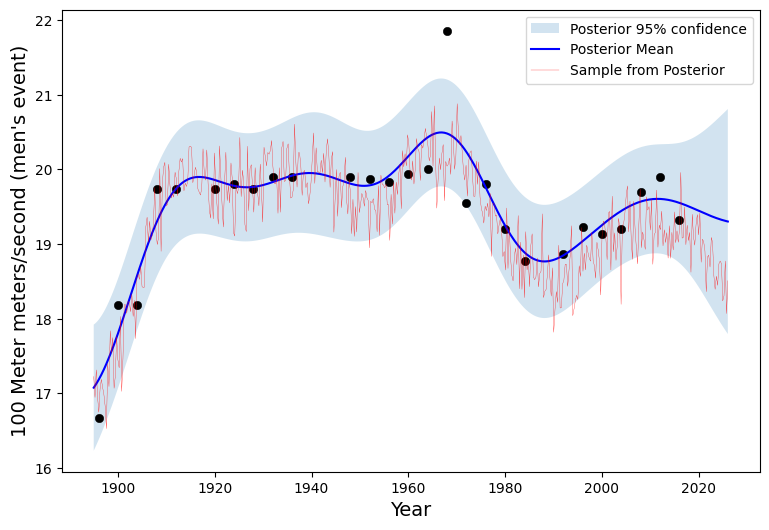

In [217]:
# 100 Meter Men
event_name = '100M Men'
event_info = dat[dat['Event'] == event_name]
event_info = event_info[event_info['Medal']=='G']
event_info = event_info.sort_values('Year')
year = np.array(event_info['Year'])
time = np.array(event_info['Result'])
mps = []
for tm in time:
  if (tm[1] == ':'):
    tm = tm[2:]
  t = np.array(tm.split('.'), dtype=float)
  meters_per_second = (200/(t[0] + t[1]/60))
  mps.append(meters_per_second)
result = np.array(mps)
mean = sum(mps)/len(mps)
noise = 0.1
gp_olympic_event(year, result, K_fun, mean, noise, "100 Meter meters/second (men's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

In this particular case, I chose higher noise values as the data was very very variable and would cause noise, likely due to the short distance of the event causing very different m/s speeds as compared to a longer distance in addition to the fact that there was one outlying point in the 60s with an insanely fast m/s time that i didnt want to overfit to.

* Why the plot does or doesn't look satisfactory to you

This plot looks quite satisfactory as the posterior mean seems to fit the data quite well and has a tight 95% confidence interval despite the outliers and high variance of the data. The function looks relatively smooth.

* If there are any events such as the 1904 marathon that are notable.

the first data point and the point in the 60s show massive outliers, the former being very low and the latter being unbelievably high speed.

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean follows where it was going but slowly trends toward the overall mean of the data points.

* Something interesting

the high variance in the data is interesting and likely caused by the shortness of the run allowing less time for a m/s to be calculated.

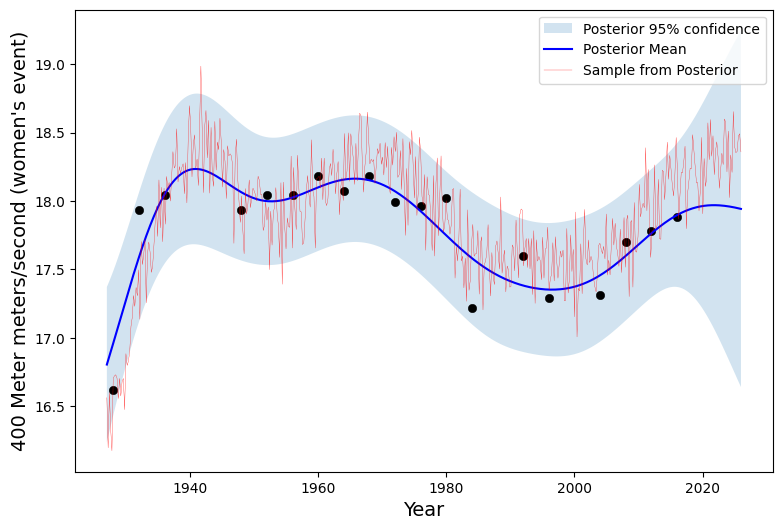

In [246]:
# 100 Meter Women
event_name = '100M Women'
event_info = dat[dat['Event'] == event_name]
event_info = event_info[event_info['Medal']=='G']
event_info = event_info.sort_values('Year')
year = np.array(event_info['Year'])
time = np.array(event_info['Result'])
mps = []
for tm in time:
  if (tm[1] == ':'):
    tm = tm[2:]
  t = np.array(tm.split('.'), dtype=float)
  meters_per_second = (200/(t[0] + t[1]/60))
  mps.append(meters_per_second)
result = np.array(mps)
mean = sum(mps)/len(mps)
noise = 0.04
gp_olympic_event(year, result, K_fun, mean, noise, "400 Meter meters/second (women's event)")

* How you chose the kernel, mean, and noise.

I chose the RBF kernel that I did as it is the most versatile of all kernels given the underlying function is smooth and is easy to tune as it only has one hyperparameter h.  The length scale parameter h in the RBF kernel determines how quickly the function values can change. By adjusting h, the kernel can be made more sensitive to local variations or more biased towards global trends, which is an important thing to tune in this example of olympic timings over the years.

I chose the mean based on the mean of the data points we had present as I felt it would be best for bridging data gaps considering the rest of the data and remaining relatively stable.

I chose the noise values I did as I know that too high a noise can cause underfitting and too low a noise can cause overfitting. I looked at the apparent variance of the noise of the data and adjusted the noise value according to what produced the best fit graph without under or overfitting.

In this particular case, I chose a slightly higher noise value as the data was a bit more variable, likely due to the short distance of the event causing very different m/s speeds as compared to a longer distance but unlike the men's there was only one outlier and that didnt impact the mean too much and thus this didnt require as high a noise param to fit well.

* Why the plot does or doesn't look satisfactory to you

This plot looks somewhat satisfactory as the posterior mean seems to fit the data quite well and has a relatively tight 95% confidence interval despite the outlier and high variance of the data. The function looks relatively smooth. Again however, like with a lot of the womens' events, CI is quick to widen.

* If there are any events such as the 1904 marathon that are notable.

the first data point is a very low speed and so is the one right after 1980.

* What happens to the posterior mean (for example during WWII) if there are gaps in the data

The posterior mean follows where it was going but slowly trends toward the overall mean of the data points. Here it falls due to two low outliers.

* Something interesting

the high variance in the data is interesting and likely caused by the shortness of the run allowing less time for a m/s to be calculated.

## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa22/main/assignments/assn1/double.jpg" width="200" align="left" style="margin:10px 30px 10px 0px"></a>


In this problem you will explore the "double descent" phenomenon that was recently
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator.
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$.
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot
the squared-bias, variance, and risk together on the same plot.
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks,
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [3]:
def OLS_or_minimum_norm(X, y):
    n, p = X.shape
    if p < n:
        # OLS solution
        beta_hat = np.linalg.solve(X.T @ X, X.T @ y)
    else:
        # Minimum norm solution
        beta_hat = X.T @ np.linalg.solve(X @ X.T, y)
    return beta_hat



In [4]:
# A plotting function we provide. No need to change this, although you can if you'd like.

def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    gammas = gammas[:13] + gammas[14:]
    risk = risk[:13] + risk[14:]
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup

The following cell sets up our data. The inputs $X$ are
random Gaussian vectors of dimension $d=10$. Then, we map these
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed.
This defines the true model.


In [5]:
# just execute this cell, after you define the function above.

np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$.
When $p < p^*$ we just take the first $p$ features in the true model.
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their
own random weights.

In the code below, we loop over the different values of $\gamma$,
and for each $\gamma$ we run $100$ trials, each time generating
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [ ]:
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
for gamma in gammas:
    err = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


gamma=0.01  p=2  n=200  risk=7.366
gamma=0.05  p=10  n=200  risk=4.146
gamma=0.10  p=20  n=200  risk=2.294
gamma=0.20  p=40  n=200  risk=2.099
gamma=0.30  p=60  n=200  risk=2.267
gamma=0.40  p=80  n=200  risk=2.534
gamma=0.50  p=100  n=200  risk=3.011
gamma=0.60  p=120  n=200  risk=3.573
gamma=0.70  p=140  n=200  risk=4.443
gamma=0.80  p=160  n=200  risk=6.885
gamma=0.90  p=180  n=200  risk=15.773
gamma=0.92  p=184  n=200  risk=20.500
gamma=0.94  p=188  n=200  risk=31.661
gamma=1.10  p=220  n=200  risk=24.179
gamma=1.20  p=240  n=200  risk=14.097
gamma=1.40  p=280  n=200  risk=8.089
gamma=1.60  p=320  n=200  risk=6.543
gamma=2.00  p=400  n=200  risk=5.301
gamma=3.00  p=600  n=200  risk=4.073
gamma=4.00  p=800  n=200  risk=3.658
gamma=5.00  p=1000  n=200  risk=3.430
gamma=6.00  p=1200  n=200  risk=3.309
gamma=7.00  p=1400  n=200  risk=3.135
gamma=8.00  p=1600  n=200  risk=3.190
gamma=9.00  p=1800  n=200  risk=3.056
gamma=10.00  p=2000  n=200  risk=3.062


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below.
This should reveal the "double descent" behavior.


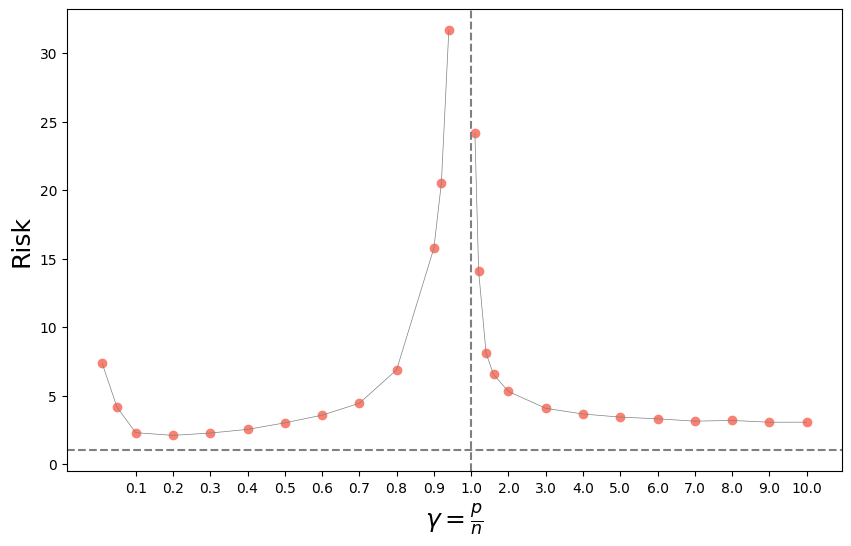

In [ ]:
# Just evaluate the next line
plot_double_descent_risk(gammas, risk, sigma)

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


**Underparameterized Regime** (gamma<1):
In this regime, as γ increases, the risk initially decreases, reaching a minimum around γ= 0.20. Beyond this point, the risk starts to increase again.
The curve in this regime is not perfectly "U-shaped", but it does have a pronounced decrease as lambda began increasing from the beginning and then steep rise as gamma approached 1, there was a clear minimum at the bottom of the dip which indicates a region where the model has optimal complexity relative to the amount of data available . This is likely where the tradeoff is optimal.

and

**Overparameterized Regime** (γ>1):
Beyond γ=1, we enter the overparameterized regime. Here, the risk initially shoots up, peaking as it approaches 1, after which it starts to decline in the overparameterized regime when gamma > 1.
The decline in risk in the overparameterized regime suggests that the double descent phenomenon does indeed occur in this model in the overparameterized regime

### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment
on the shape of the bias and variance curves, as above for Problem 3.2.


In [12]:
# Your code and markdown here.

# Initialize variables for experiment
trials = 100
n = 200
gammas = [.01, .05] + list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
risk = []
squared_bias_list = []
variances = []

# Fix the test set
_, X_test, _, yf_test = train_test_split(X, yf, train_size=1, test_size=1000)

# Loop over different values of gamma
for gamma in gammas:
    err = []
    estimates = []
    p = int(n * gamma)

    if gamma == 1:
        risk.append(np.inf)
        squared_bias_list.append(np.inf)
        variances.append(np.inf)
        continue

    W = (1 / np.sqrt(d)) * np.random.randn(d, p)
    W[:, :min(p, p_star)] = W_star[:, :min(p, p_star)]

    for i in range(trials):
        X_train, _, yf_train, _ = train_test_split(X, yf, train_size=n)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:, 0])
        yhat_test = H_test @ beta_hat
        err.append(np.mean((yhat_test - yf_test[:, 0]) ** 2))
        estimates.append(yhat_test)

    # Compute risk (MSE)
    risk.append(np.mean(err))

    # Compute squared bias
    avg_predictions = np.mean(estimates, axis=0)
    squared_bias = np.mean((avg_predictions - yf_test[:, 1]) ** 2)
    squared_bias_list.append(squared_bias)

    # Compute variance
    variance = np.mean(np.var(estimates, axis=0))
    variances.append(variance)

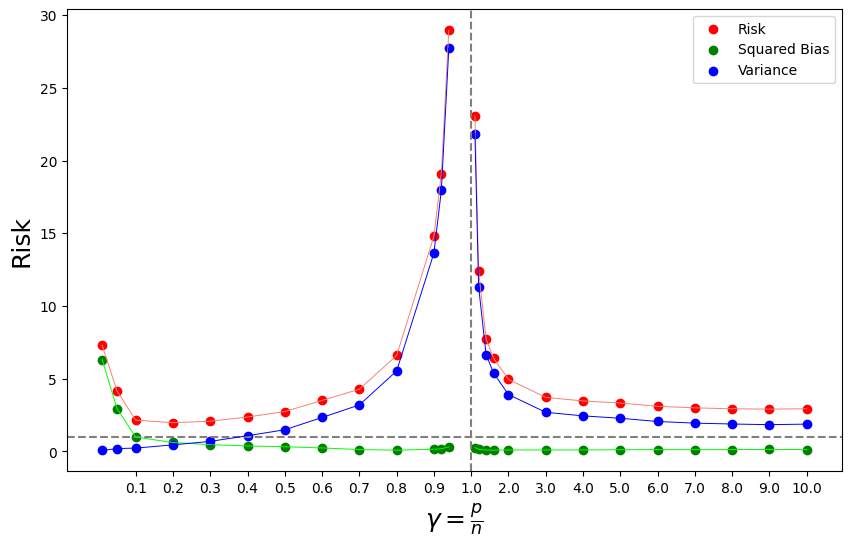

In [11]:
def plot_double_descent_curves(gammas, risk, squared_bias, variance, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Custom tick positions
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9

    # Plot vertical and horizontal dashed lines
    ax.axvline(x=tick_pos[np.array(gammas) == 1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')

    # Plot data points and curves
    ax.scatter(tick_pos, risk, color='red', label='Risk')
    ax.plot(tick_pos, risk, color='salmon', linewidth=0.7)
    ax.scatter(tick_pos, squared_bias, color='green', label='Squared Bias')
    ax.plot(tick_pos, squared_bias, color='lime', linewidth=0.7)
    ax.scatter(tick_pos, variance, color='blue', label='Variance')
    ax.plot(tick_pos, variance, color='blue', linewidth=0.7)

    # Custom tick labels
    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    # Axes labels and legend
    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    plt.ylabel('Risk', fontsize=18)
    plt.legend()

    plt.show()

    # Plot the results
plot_double_descent_curves(gammas, risk, squared_bias_list, variances, sigma)

To begin with, we see expected behavior in the underparameterized regime with the bias starting high at low gammas and steadily decreasing to a minimum and remaining low throughout the underparameterized gammas before ever so slightly increasing as it approaches 1. With variance we see expected behavior with low variance to begin with and rapidly increasing variance as the model overfits as gammas approach 1, with an associated spike in risk. The risk behavior looks appropriate, starting high and following the squared bias down until the crossover with variance, at which point risk begins to increase with variance and the intersection approximately landing near the lowest risk value in the underparameterized regime.

In the overparameterized regime however, we see the ever so slightly elevated bias decrease back to a steady minimum and the variance rapidly decrease along with the risk as gamma grew past 1. This is accurate and an expected display of the double descent phenomenon.

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $.

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might consider using the Woodbury formula twice.



![convert notebook to web app](https://rstr.in/avjn9edat3zttr/my-library/rNeNApTEXS9)